In [24]:
#Importing Libraries
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
#Loading and separating only the text
df_raw = pd.read_csv('tweets_raw.csv')
df = pd.DataFrame()
df['full_text'] = df_raw['full_text']

In [5]:
#Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

In [10]:
df['processed_text'] = df['full_text'].apply(preprocess_text)

In [13]:
nlp = spacy.load('en_core_web_sm')

In [22]:
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT']]
    extract_entities.counter += 1
    print(f"Processing entity {extract_entities.counter}: {entities} out of 30000")
    clear_output(wait=True)
    return entities
extract_entities.counter = 0

In [25]:
df['entities'] = list(tqdm(df['full_text'].apply(extract_entities), total=len(df)))

100%|██████████| 30000/30000 [00:00<00:00, 1999922.44it/s]


In [27]:
#Counting entity occurrences
entities_count = Counter([entity for entities in df['entities'] for entity in entities])

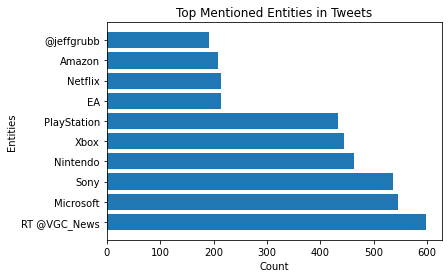

In [30]:
#Display top mentioned entities
top_entities = entities_count.most_common(10)
entity_names, entity_counts = zip(*top_entities)

#Create a bar chart
plt.barh(entity_names, entity_counts)
plt.xlabel('Count')
plt.ylabel('Entities')
plt.title('Top Mentioned Entities in Tweets')
plt.show()

In [33]:
#Sentiment analysis
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sia.polarity_scores(text)['compound']
    if sentiment >= 0.1:
        return 'Positive'
    elif sentiment <= -0.1:
        return 'Negative'
    else:
        return 'Intermediate'

In [34]:
df['sentiment'] = df['full_text'].apply(get_sentiment)

In [37]:
# Convert the lists in the 'entities' column to strings
df['entities'] = df['entities'].apply(lambda x: ', '.join(x))

In [38]:
#Aggregate sentiment scores for each topic
aggregated_sentiment = df.groupby('entities')['sentiment'].value_counts().unstack().fillna(0)

In [39]:
#Determine general opinion for each topic
aggregated_sentiment['General Opinion'] = aggregated_sentiment.idxmax(axis=1)

In [65]:
#Calculate word frequencies
word_freq = pd.Series([word for tokens in df['processed_text'] for word in tokens]).value_counts()

In [66]:
#Display word frequencies table
word_freq_table = pd.DataFrame({'Word': word_freq.index, 'Frequency': word_freq.values})
print(word_freq_table)

               Word  Frequency
0             https      49562
1              game       4124
2               new       3571
3             games       3086
4              xbox       1622
...             ...        ...
20522      yeehawin          1
20523        santas          1
20524         shack          1
20525  ecologically          1
20526          tali          1

[20527 rows x 2 columns]


In [67]:
#Aggregate sentiment scores for each topic
aggregated_sentiment = df.groupby('entities')['sentiment'].value_counts().unstack().fillna(0)


In [68]:
aggregated_sentiment['General Opinion'] = aggregated_sentiment.idxmax(axis=1)

In [71]:
aggregated_sentiment

sentiment,Intermediate,Negative,Positive,General Opinion
entities,,,,
,5633.0,3190.0,4581.0,Intermediate
"#Anime, JumpForce",0.0,0.0,1.0,Positive
#Arcade Archives,2.0,1.0,2.0,Intermediate
"#Arcade Archives’ Future Ninja, Namco",0.0,0.0,1.0,Positive
#Brands,0.0,0.0,1.0,Positive
...,...,...,...,...
💦,0.0,0.0,1.0,Positive
"💦, 💦",0.0,0.0,1.0,Positive
📜,0.0,0.0,1.0,Positive


In [73]:
aggregated_sentiment.to_csv('output_data/aggregated_sentiment.csv')